In [1]:
import os, shutil
import flopy as fp
import numpy as np
import pyemu
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Quick check for Windows to make sure input files are Windows type
import platform
if 'window' in platform.platform().lower():
    ppp = 'pest++'
    newln='\n'
else:
    ppp='pestpp'
    newln='\r\n'
    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator


setting random seed


### Let's load up a couple arrays we will need for visualizing results

In [2]:
base_dir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(base_dir,cf),cf) for cf in os.listdir(base_dir)];
if not os.path.exists('base_pp_dir'):
    os.mkdir('base_pp_dir')
[shutil.copy2(os.path.join(base_dir,cf),os.path.join('base_pp_dir',cf)) for cf in os.listdir(base_dir)];


In [3]:
# Since this is a sythetic example, we can load up the true K field to compare our answers to 
HK_truth = np.loadtxt(os.path.join('..','..','models','Freyberg','Freyberg_Truth','hk.truth.ref'))
# ibound can be used to mask inactive areas
ib = np.loadtxt('ibound.ref')
HK_truth[ib==0] = np.nan

# Set up a couple functions to help with displaying results

In [4]:
def update_K(inpstname):
    optpst = pyemu.Pst(inpstname + '.pst')
    # reset the parameter values using the best parameters from the last run
    optpst.parrep(inpstname + '.bpa')
    # set NOPTMAX=0 to run the model just a single time
    optpst.control_data.noptmax=0
    # write out the PST file with a new name
    optpst.write(inpstname + '_opt.pst')
    # run the new version of the model
    os.system('{0} {1}_opt.pst'.format(ppp, inpstname))

In [5]:
def plot_K_results(inpstname):
    HK_best = np.loadtxt('hk.ref')
    HK_best[ib==0] = np.nan
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
    im1=ax1.imshow(HK_truth, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="20%", pad=0.05)
    cbar1 = plt.colorbar(im1, cax=cax1,format="%.2f")

    im2=ax2.imshow(HK_best, interpolation='nearest', cmap='viridis', vmin = np.nanmin(HK_truth), vmax = np.nanmax(HK_truth))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="20%", pad=0.05)
    cbar2 = plt.colorbar(im2, cax=cax2,  format="%.2f")

    im3=ax3.imshow(HK_best, interpolation='nearest', cmap='viridis')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="20%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3,  format="%.2f")
    plt.tight_layout()
    plt.savefig(inpstname + 'HK_.pdf')
    
    plt.figure()
    inphi = pd.read_csv(inpstname +'.iobj')
    inphi[['total_phi','measurement_phi', 'regularization_phi']].plot()
    plt.gca().set_yscale('log')
    plt.ylabel('PHI')
    plt.xlabel('Iteration Number')

# Pilot Points with Regularization controlled by `reg_frac`
There are a couple ways to control regularization in `pest++`. This time we will cover using the variable `phimlim`

## First we can run without regularization (e.g. `reg_frac` is very low)

In [24]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.pestpp_options

{'forecasts': 'rivflux_fore,travel_time,fr03c16,fr04c9',
 'max_n_super': '25',
 'n_iter_base': '-1',
 'n_iter_super': '4',
 'super_eigthres': '1.0e-8'}

In [25]:
frac_reg_0p01 = 'freyberg_pp_reg_regfrac0p01'
inpst.pestpp_options['reg_frac']=0.01
inpst.write(frac_reg_0p01 + '.pst')
shutil.copy2('{0}.pst'.format(frac_reg_0p01), os.path.join('base_pp_dir','{0}.pst'.format(frac_reg_0p01)))

'base_pp_dir\\freyberg_pp_reg_regfrac0p01.pst'

In [26]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),"{0}.pst".format(frac_reg_0p01),20,slave_root='.',port=4004,master_dir='.')

In [27]:
update_K(frac_reg_0p01)

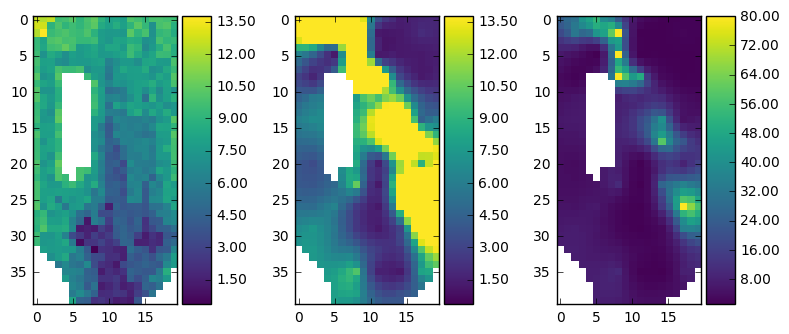

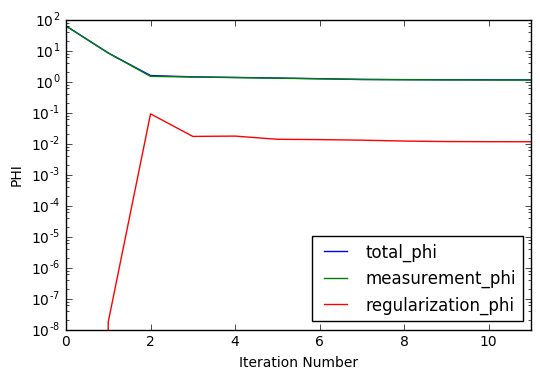

In [28]:
plot_K_results(frac_reg_0p01)

In [29]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
inpst.pestpp_options

{'forecasts': 'rivflux_fore,travel_time,fr03c16,fr04c9',
 'max_n_super': '25',
 'n_iter_base': '-1',
 'n_iter_super': '4',
 'super_eigthres': '1.0e-8'}

### Let's increase `frac_reg` to 50%

In [30]:
frac_reg_0p5 = 'freyberg_pp_reg_regfrac0p5'
inpst.pestpp_options['reg_frac']=0.5
inpst.write(frac_reg_0p5 + '.pst')
shutil.copy2('{0}.pst'.format(frac_reg_0p5), os.path.join('base_pp_dir','{0}.pst'.format(frac_reg_0p5)))


'base_pp_dir\\freyberg_pp_reg_regfrac0p5.pst'

In [31]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),'{0}.pst'.format(frac_reg_0p5),20,slave_root='.',port=4004,master_dir='.')

In [32]:
update_K(frac_reg_0p5)

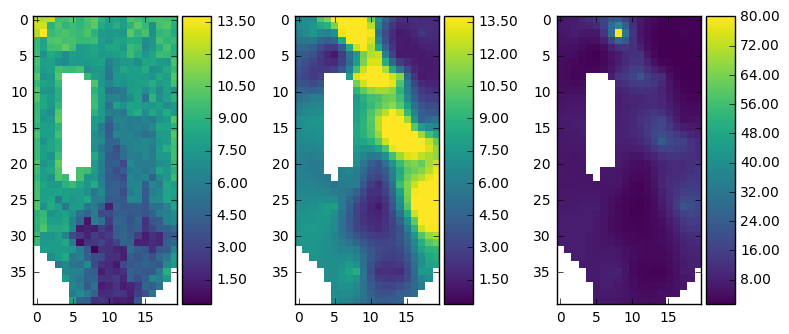

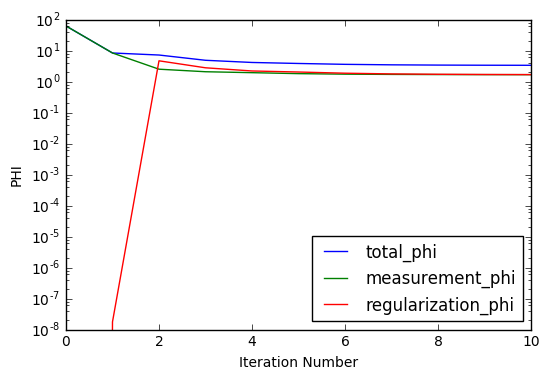

In [33]:
plot_K_results(frac_reg_0p5)

### How about 75%?

In [34]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
frac_reg_0p75 = 'freyberg_pp_reg_regfrac0p75'
inpst.pestpp_options['reg_frac']=0.75
inpst.write(frac_reg_0p75 + '.pst')
shutil.copy2('{0}.pst'.format(frac_reg_0p75), os.path.join('base_pp_dir','{0}.pst'.format(frac_reg_0p75)))

'base_pp_dir\\freyberg_pp_reg_regfrac0p75.pst'

In [35]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),'{0}.pst'.format(frac_reg_0p75),20,slave_root='.',port=4004,master_dir='.')

In [37]:
update_K(frac_reg_0p75)

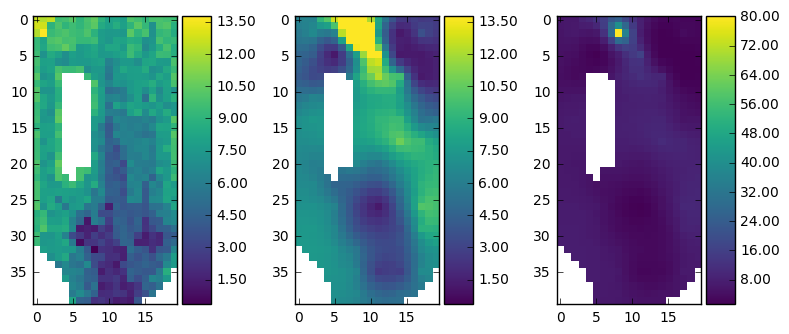

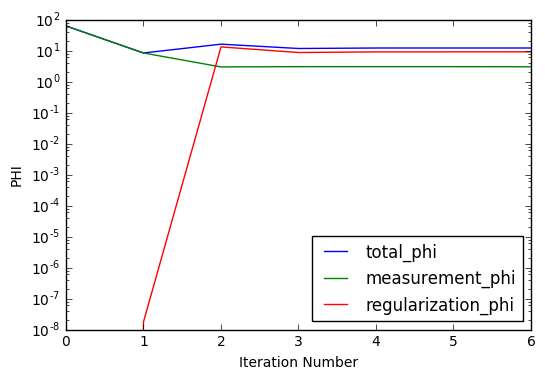

In [38]:
plot_K_results(frac_reg_0p75)

### Finally, how about `frac_reg=90%`?

In [39]:
inpst = pyemu.Pst('freyberg_pp_reg.pst')
frac_reg_0p9 = 'freyberg_pp_reg_regfrac0p9'
inpst.pestpp_options['reg_frac']=0.9
inpst.write(frac_reg_0p9 + '.pst')
shutil.copy2('{0}.pst'.format(frac_reg_0p9), os.path.join('base_pp_dir','{0}.pst'.format(frac_reg_0p9)))

'base_pp_dir\\freyberg_pp_reg_regfrac0p9.pst'

In [40]:
pyemu.utils.start_slaves('base_pp_dir',"{0}".format(ppp),'{0}.pst'.format(frac_reg_0p9),20,slave_root='.',port=4004,master_dir='.')

In [41]:
update_K(frac_reg_0p9)

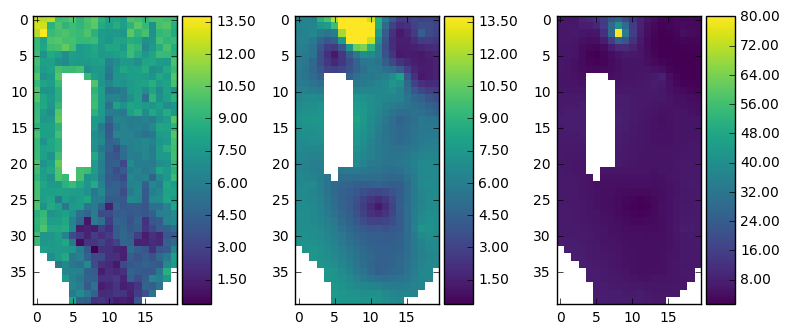

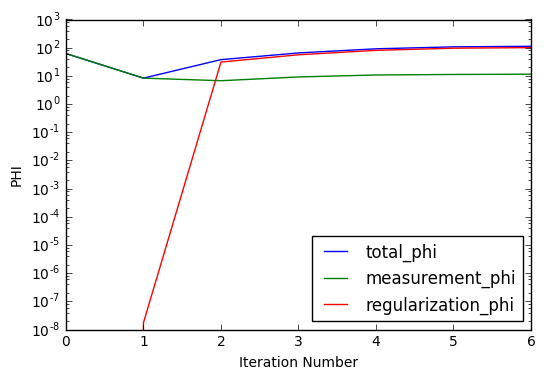

In [42]:
plot_K_results(frac_reg_0p9)